In [1]:
import os
from pathlib import Path

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sns.set_context("paper")
sns.set(style="whitegrid")

from nilearn import plotting
import nibabel as nb

from scipy.stats import zscore
from scipy.stats import ttest_1samp

import statsmodels.formula.api as smf
from statsmodels.stats import weightstats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

## Load data

In [2]:
full_sample = pd.read_csv("full_sample_stats.tsv", sep="\t", index_col=0).drop("sub-10298")
copes_task = pd.read_csv("FSL_task/copes.tsv", sep="\t", index_col=0)
copes_hrv = pd.read_csv("FSL_hrv/copes.tsv", sep="\t", index_col=0)
hrv = pd.read_csv("mri_sample_hrv.tsv", sep="\t", index_col=0)

# Handle outliers in HRV
for var in hrv.columns:
    m = hrv[var].mean()
    median = hrv[var].median()
    sd = hrv[var].std()
    out = abs((hrv[var] - m) / sd) > 2.5
    hrv[var][out] = median

## Behavioural task performance
| Data labels | Terms used in the manuscript |
|-------------|------------------------------|
|Accuracy  |  Accuracy|
|Sensibility | Confidence|
|Awareness | Insight|

We first describe participant performance on the heart beat detection paradigm. 
Confidence-accuracy correspondence using areas under an ROC were calculated to present participants' metacognitive insight in each task condition. 
Overall both groups demonstrated levels of interoceptive accuracy within the scanning environment that did not significantly differ from chance performance. 

In [3]:
tstat, pval= ttest_1samp(full_sample["HeartAcc"][full_sample["group"]=="control"], 0.5)
print(f"HeartAcc control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["HeartAcc"][full_sample["group"]=="patient"], 0.5)
print(f"HeartAcc patient: t = {tstat:.3f}, p = {pval:.3f}")

HeartAcc control : t = -0.130, p = 0.898
HeartAcc patient: t = 0.893, p = 0.377


However, the subjective report of confidence shows both the FEP patients are confident with their responses. 

In [4]:
tstat, pval= ttest_1samp(full_sample["HeartSensib"][full_sample["group"]=="control"], 25)
print(f"HeartSensib control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["HeartSensib"][full_sample["group"]=="patient"], 25)
print(f"HeartSensib patient: t = {tstat:.3f}, p = {pval:.3f}")

HeartSensib control : t = 2.118, p = 0.047
HeartSensib patient: t = 3.277, p = 0.002


Consistent with variable near-chance performance accuracy, overall interoceptive insight (derived from confidence-accuracy correspondence) did not differ significantly from chance for the FEP patients and controls. 

In [5]:
tstat, pval= ttest_1samp(full_sample["HeartAware"][full_sample["group"]=="control"], 0.50)
print(f"HeartAware control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["HeartAware"][full_sample["group"]=="patient"], 0.50)
print(f"HeartAware patient: t = {tstat:.3f}, p = {pval:.3f}")

HeartAware control : t = 0.346, p = 0.733
HeartAware patient: t = 0.583, p = 0.563


For the control exteroceptive condition, both patients and control has performance above chance, confident with their performance, hence the insight scores are also significant. 

In [6]:
tstat, pval= ttest_1samp(full_sample["NoteAcc"][full_sample["group"]=="control"], 0.5)
print(f"NoteAcc control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["NoteAcc"][full_sample["group"]=="patient"], 0.5)
print(f"NoteAcc patient: t = {tstat:.3f}, p = {pval:.3f}")

tstat, pval= ttest_1samp(full_sample["NoteSensib"][full_sample["group"]=="control"], 25)
print(f"NoteSensib control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["NoteSensib"][full_sample["group"]=="patient"], 25)
print(f"NoteSensib patient: t = {tstat:.3f}, p = {pval:.3f}")


tstat, pval= ttest_1samp(full_sample["NoteAware"][full_sample["group"]=="control"], 0.50)
print(f"NoteAware control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["NoteAware"][full_sample["group"]=="patient"], 0.50)
print(f"NoteAware patient: t = {tstat:.3f}, p = {pval:.3f}")

NoteAcc control : t = 8.057, p = 0.000
NoteAcc patient: t = 8.957, p = 0.000
NoteSensib control : t = 9.105, p = 0.000
NoteSensib patient: t = 11.409, p = 0.000
NoteAware control : t = 3.106, p = 0.006
NoteAware patient: t = 4.735, p = 0.000


We performed mixed design ANOVAs with subject groups as between-subject measures (control - patient) and task condition as within subject measures (Heart (interoceptive) - Note(exteroceptive)). 
The same model was used to predict three measures representing different aspects of the task performance: accuracy, confidence (subjective rating on performance), and insight (confidence-accuracy correspondence). 
We observe main effects of task condition in accuracy (F(1, 59)=74.77, p<.001), metacognitive insights (F(1, 59)=12.41, p<.001) and confidence (F(1, 59)=29.32, p<.001), showing significant difference between the two conditions. 
There was no main effect of group (accuracy: F(1, 59)=0.369, p=0.546; metacognition: F(1, 59)=0.052, p=0.820; confidence: F(1, 59)=0.057, p=0.785) and no group by task condition interaction (accuracy: F(1, 59)=2.556, p=0.115; metacognition: F(1, 59)=0.025, p=0.874; confidence: F(1, 59)=0.201, p=0.665), detailing that performance on the interoceptive versus exteroceptive task did not differ with patients. 

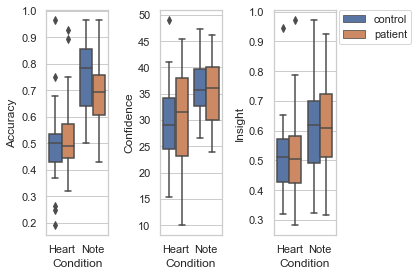

In [7]:
fig, ax =  plt.subplots(1, 3)
i = 0
for s, measure in zip(["Acc", "Sensib", "Aware"], ["Accuracy", "Confidence", "Insight"]):
    plot_data = full_sample.loc[:, [f"Heart{s}", f"Note{s}", "group"]]
    plot_data["participant_id"] = plot_data.index
    plot_data = plot_data.melt(id_vars=["participant_id", "group"])
    plot_data.columns = ["participant_id", "Group", "Condition", measure]
    plot_data = plot_data.replace(f"Heart{s}", "Heart")
    plot_data = plot_data.replace(f"Note{s}", "Note")
    g = sns.boxplot(x="Condition", y=measure, hue="Group", 
                    data=plot_data, ax=ax[i])
    if i < 2:
        g.legend_.remove()
    else: 
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    i += 1
plt.tight_layout()
plt.savefig("figures/task_performance.png", dpi=300)

__In summary, the performance and subjective confidence rating differs between  the two task conditions, but there are no differences between the patients and controls.__

## Interoceptive insight and dissociation state

In [8]:
desc_cds_patient = full_sample[
    ["CDS_State", "AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot"]][
    full_sample["group"]=="patient"].describe()
desc_cds_control = full_sample[["CDS_State"]][full_sample["group"]=="control"].describe()
desc_cds_control.columns = pd.MultiIndex.from_product([["CDS state score"], ['Control']])
desc_cds_patient.columns = pd.MultiIndex.from_product([["CDS state score", 
                                                        "Alienation from surroundings", 
                                                        "Anomalous subjective recall", 
                                                        "Emotion numbing", 
                                                        "Anomalous body experience"], ['Patient']])

pd.concat([desc_cds_control, desc_cds_patient], axis=1)

CDS state score             Alienation from surroundings  \
              Control     Patient                      Patient   
count       21.000000    40.00000                    40.000000   
mean       120.761905   304.75000                    11.700000   
std        192.503741   298.81988                     7.501111   
min          2.000000     0.00000                     0.000000   
25%         25.000000    59.00000                     6.000000   
50%         54.000000   197.00000                    10.000000   
75%        114.000000   492.25000                    17.000000   
max        877.000000  1144.00000                    26.000000   

      Anomalous subjective recall Emotion numbing Anomalous body experience  
                          Patient         Patient                   Patient  
count                   40.000000       40.000000                  40.00000  
mean                    11.325000       11.900000                  14.47500  
std                      8.858973       10.700587                  15.85671  
min                      0.000000        0.000000                   0.00000  
25%                      5.000000        2.750000                   3.00000  
50%                      9.500000       10.000000                  10.00000  
75%                     14.250000       19.000000                  16.50000  
max                     35.000000       38.000000                  70.00000

Assessments scores and dessociated state were collected in both control and patients. Some trait level scores were measured in patients only, characterised by total duration spent on different type of scenrio: 
 - Alienation from surroundings
 - Anomalous subjective recall
 - Emotion numbing
 - Anomalous body experience. 
 
State level dissociation was significantly elevated in FEP compared to control participants.

CDS_State: t(56.35690933747776) = -2.910204228254159, p = 0.005163192288285354


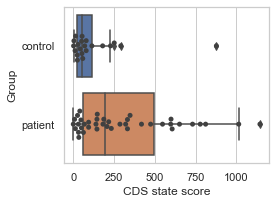

In [9]:
tstat, pval, df = weightstats.ttest_ind(full_sample["CDS_State"][full_sample["group"]=="control"], 
                                        full_sample["CDS_State"][full_sample["group"]=="patient"],
                                        usevar="unequal")
print(f"CDS_State: t({df}) = {tstat}, p = {pval}")
plot_data = full_sample[["group", "CDS_State"]]
plot_data.columns = ["Group", "CDS state score"]

plt.figure(figsize=(4,3))
sns.boxplot(y="Group", x="CDS state score",data=plot_data,)
sns.swarmplot(y="Group", x="CDS state score", data=plot_data, color=".25")
plt.tight_layout()
plt.savefig("figures/cds_ttest.png", dpi=300)

To further understand the trait level dissociation in relation to interoception, we use a regression model to characterised the association between metacognitive insight and the four CDS trait subscales in FEP group. 

We observed that cardiac interoceptive insight score negatively correlated with the overall model consisting of the four trait dissociation subscales. Within the four sub-dimensions of the dissociation scale, alienation from surroundings contribute most to the overall model, however, this effect is small after Bonferroni correction (pcorrected = 0.044, alpha = 0.05). No relationship was observed with anomalous subjective recall, emotional numbing, and anomalous body experience. 

In [10]:
fep_stat = ["HeartAware", "AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot", ]
fep_stat = full_sample[fep_stat][full_sample["group"] == "patient"]
mod = smf.ols(formula=f'HeartAware ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())
reject, p_corrected, _, alphaBonf = multipletests(res.pvalues, method='holm-sidak', is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values, index=res.pvalues.index, columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
corrected_p

                            OLS Regression Results                            
Dep. Variable:             HeartAware   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     3.499
Date:                Wed, 10 Mar 2021   Prob (F-statistic):             0.0167
Time:                        16:28:00   Log-Likelihood:                -50.030
No. Observations:                  40   AIC:                             110.1
Df Residuals:                      35   BIC:                             118.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -6.87e-16      0.143  

,uncorrected,corrected
Intercept,1.000000,1.000000
AlienSurroundTot,0.008933,0.043874
AnomSubRecTot,0.991472,0.999927
EmoNumTot,0.638616,0.952804
AnomBodyExpTot,0.224747,0.638779


In [11]:
select_name = ["Interoceptive insight",
               "Alienation from surroundings", 
               "Anomalous subjective recall", 
               "Emotion numbing", 
               "Anomalous body experience", 
               
              ]
fep_stat.columns = select_name

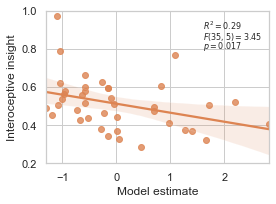

In [12]:
sns.set_context("paper")
sns.set(style="whitegrid")
plt.figure(figsize=(4, 3))
g = sns.regplot(x=zscore(fep_stat[select_name[1:]].values.sum(axis=1)), 
                y="Interoceptive insight", 
                data=fep_stat,
                color=sns.color_palette()[1])
g.set_ylim(0.2, 1)
g.set_xlabel("Model estimate")
g.annotate(r"$R^{2}=0.29$", (1.6, 0.90), fontsize=8)
g.annotate(r"$F(35, 5)=3.45$", (1.6, 0.85), fontsize=8)
g.annotate(r"$p=0.017$", (1.6, 0.8), fontsize=8)
plt.tight_layout()
plt.savefig("figures/metacog_CDStrait_model.png", dpi=300)

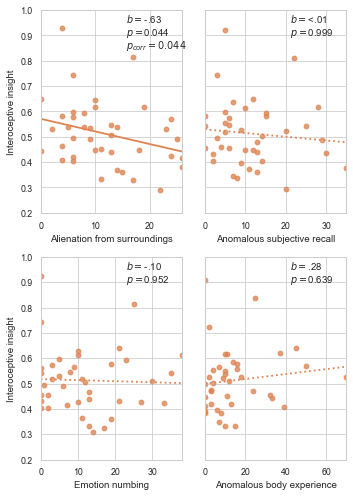

In [13]:
sns.set_context("paper")
fig, axes = plt.subplots(2, 2, figsize=(5, 7))
for i, (x, stats) in enumerate(zip(select_name[1:],[("-.63", "0.044"),
                                                     ("<.01", "0.999"),
                                                     ("-.10", "0.952"),
                                                     (".28", "0.639")])):
    ci = False 
    partial = [i for i in select_name[1:] if i != x]
    if x == "Alienation from surroundings":
        ci = True
    g = sns.regplot(x=x, y="Interoceptive insight", data=fep_stat, 
                    y_partial=zscore(fep_stat[partial].values.sum(axis=1)),
                    fit_reg=True, ax=axes[int(i / 2), np.mod(i, 2)],
                    color=sns.color_palette()[1], ci=ci
                   )
    if x != "Alienation from surroundings":
        g.lines[0].set_linestyle(":")
    g.set_ylim(0.2, 1)
    g.set_ylabel("Interoceptive insight")
    g.set_xlim(0, fep_stat[x].max())
    if np.mod(i, 2) != 0:
        g.set_ylabel("")
        g.set(yticklabels=[])
    
    ano_x_start = fep_stat[x].max() - fep_stat[x].max() * 0.4
    g.annotate(r"$b=$" + stats[0], (ano_x_start, 0.95))
    g.annotate(r"$p=$" + stats[1], (ano_x_start, 0.9))
    if i ==0:
        g.annotate(r"$p_{corr}=0.044$", (ano_x_start, 0.85))
    

plt.tight_layout()
plt.savefig(f"figures/metacog_CDStrait_subscale.png", dpi=300)

The same model predicting exteroceptive insight score was not significant (r2 = .11, F(35, 5)=1.12, p=0.363).

In [14]:
fep_stat = ["NoteAware", "AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot", ]
fep_stat = full_sample[fep_stat][full_sample["group"] == "patient"]
mod = smf.ols(formula=f'NoteAware ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())
reject, p_corrected, _, alphaBonf = multipletests(res.pvalues, method='holm-sidak', is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values, index=res.pvalues.index, columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
corrected_p

                            OLS Regression Results                            
Dep. Variable:              NoteAware   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.120
Date:                Wed, 10 Mar 2021   Prob (F-statistic):              0.363
Time:                        16:28:03   Log-Likelihood:                -54.349
No. Observations:                  40   AIC:                             118.7
Df Residuals:                      35   BIC:                             127.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          1.11e-16      0.159  

,uncorrected,corrected
Intercept,1.000000,1.000000
AlienSurroundTot,0.425542,0.810428
AnomSubRecTot,0.783111,0.952959
EmoNumTot,0.059305,0.263380
AnomBodyExpTot,0.173304,0.532928


__Despite the chance level performance in the interception task, the metacognitve insights from the two conditions correlated with the clinical trait in the FEP group differently.
Within the FEP group, there was variability in interoceptive performance as a function of dissociative symptoms.
We demonstrate the potential clinical relevance of the variability of the interoceptive subjective rating in heartbeat detection task.__

## Task contrast in fMRI introception > extroception

In the task contrast, we modelled the time period when participants are attending to the auditory stimuli in the interoceptive and exteroceptive conditions respectively. As the behaviorual task performance was at chance, the activation map should be seen as the effect of instructions of each condition. 
No significant differences were observed between the controls and patients. 

When pulling all subjects together, the "introception > extroception" contrast (TFCE p-FWE = 0.01) yielded bilateral insula activation, supplementary motor area, left middle temporal gyrus (MTG), bilateral angular gyrus extending into anterior supramarginal gyrus, and left dorsal medial prefrontal cortex (dmPFC) were all engaged.
For the reverse contrast, ventral medial prefrontal cortex (vmPFC), left amygdala, precuneous, parietal operculum cortex and the occipital gyrus was engaged. 

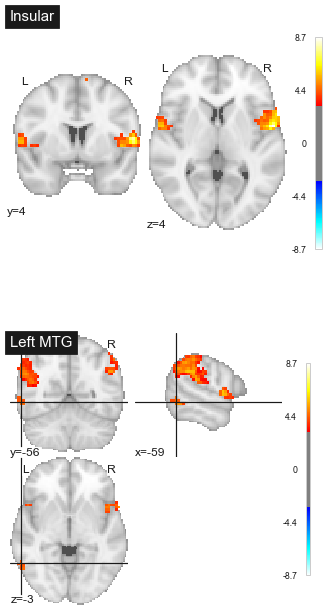

In [15]:
sig_tstat = "FSL_task/heart_wrt_note_thresh_tstat.nii.gz"

d = nb.load(sig_tstat).get_fdata()
vmax = d.max()
thr = np.unique(d)[1]

fig, ax = plt.subplots(2, 1, figsize=(5, 11))
for i, (title, display, 
        cut_coords, draw_cross) in enumerate(zip(["Insular", "Left MTG"],
                                                 ["yz", "tiled"],
                                                 [(4, 4), (-59, -56, -3)],
                                                 [False, True])):
    g = plotting.plot_stat_map(sig_tstat, title=title,
                               display_mode=display,
                               cut_coords=cut_coords,
                               draw_cross=draw_cross, colorbar=False,
                               axes=ax[i]
                              )
    g._colorbar_margin = {'left':0,
                          'right': -0.2,
                          'top': 0.037750000000000006,
                          'bottom': 0.037750000000000006}

    g._show_colorbar(cmap="cold_hot", 
                     norm=colors.Normalize(-vmax, vmax), 
                     threshold=thr)

# plt.savefig("figures/insular.png", dpi=300)

### Relationship with dissociation
To investigated the relationship between signal change and participants’ interoceptive insight on task and state of dissociation, we used all 7 clusters found by the “interoceptive > exteroceptive” contrasts to extract contrast of parameter estimate (COPE), converted to percent signal change. 
The percent signal change values are correlated with CDS state scores, interoceptive insight of the task. 
We formulated hypothesis between heartbeat and the bilateral insula regions, thus the relationship between RMSSD and the activations in bilateral insula were examined. 
Based on the previous analysis, we expected no differences between controls and patients in their interoceptive insight, therefore all statistics were performed on the full sample as a singular group.

We found four significant correlations. CDS state scores were negatively correlated with signals from the left insula and left MTG. Bilateral insula signal correlated with participants metacognitive insights. 

In [16]:
stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
stats = stats[['insular_L', 'insular_R', 'MTG_L', "CDS_State", "HeartAware", "RMSSD"]]
for x in ['insular_L', 'insular_R', 'MTG_L']:
    for y in ["CDS_State", "HeartAware", "RMSSD"]:
        mod = smf.ols(formula=f'{y} ~ {x} ', data=stats.apply(zscore))
        res = mod.fit()
        print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              CDS_State   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     5.825
Date:                Wed, 10 Mar 2021   Prob (F-statistic):             0.0198
Time:                        16:28:05   Log-Likelihood:                -66.666
No. Observations:                  49   AIC:                             137.3
Df Residuals:                      47   BIC:                             141.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.684e-17      0.138    3.4e-16      1.0

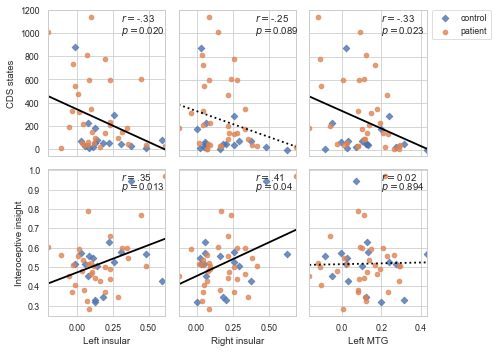

In [17]:
select_name = ["Left insular", "Right insular", "Left MTG",
               "CDS states", "Interoceptive insight","Group"
              ]
select_var = ["insular_L", "insular_R", "MTG_L",
              "CDS_State", "HeartAware", "group"]

stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
stats = stats[select_var]

data = stats[select_var]
data.columns = select_name

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
stats = [[("-.33", "0.020"), ("-.25", "0.089"), ("-.33", "0.023")], 
         [(".35", "0.013"), (".41", "0.04"), ("0.02", "0.894")]]

for j, region in enumerate(["Left insular", "Right insular", "Left MTG"]):
    for i, measure in enumerate(["CDS states", "Interoceptive insight"]):
        axes[i, j].scatter(data[data["Group"] == "control"][region], 
                     data[data["Group"] == "control"][measure], 
                     label="control", marker="D", alpha=0.8)
        axes[i, j].scatter(data[data["Group"] == "patient"][region], 
                     data[data["Group"] == "patient"][measure],
                     label="patient", marker="o", alpha=0.8)
    
        g = sns.regplot(region, measure, data=data, 
                        fit_reg=True, scatter=False, ci=None, 
                        ax=axes[i, j], color="black")
        
        if j != 0:
            axes[i, j].set_ylabel("")
            axes[i, j].set(yticklabels=[])

        if i == 0:
            axes[i, j].set_xlabel("")
            axes[i, j].set(xticklabels=[])
        if ((measure == "CDS states" and region in ["Left insular", "Left MTG"]) or
            (measure == "Interoceptive insight" and region in ["Left insular","Right insular"])):
            g.lines[0].set_linestyle("-")
        else:
            g.lines[0].set_linestyle(":")
        
        if region =="Left insular":
            x = 0.31
        elif region =="Right insular":
            x = 0.4
        else:
            x = 0.2
        if measure == "CDS states":
            y1, y2 = 1100, 1000
        else:
            y1, y2 = 0.95, 0.9
            
        g.annotate(r"$r=$" + stats[i][j][0], (x, y1))
        g.annotate(r"$p=$" + stats[i][j][1], (x, y2))
            
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

plt.savefig("figures/copes_vs_beh_scatter_original.png", dpi=300)

No significant relationships were found between RMSSD during the task and the signal changes in bilateral insula.

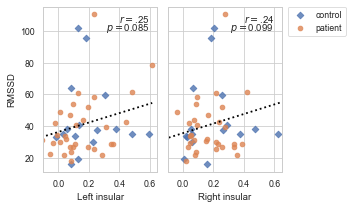

In [18]:
stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
select_name = ["Left insular", "Right insular","RMSSD","Group"]
select_var = ["insular_L", "insular_R", 
              "RMSSD", "group"]

data = stats[select_var]
data.columns = select_name

fig, axes = plt.subplots(1, 2, figsize=(5, 3))

for (i, region), stats in zip(enumerate(["Left insular", "Right insular"]),
                              [(".25", "0.085"),
                               (".24", "0.099")]):
    
    axes[i].scatter(data[data["Group"] == "control"][region], 
                 data[data["Group"] == "control"]["RMSSD"], 
                 label="control", marker="D", alpha=0.8)
    axes[i].scatter(data[data["Group"] == "patient"][region], 
                 data[data["Group"] == "patient"]["RMSSD"],
                 label="patient", marker="o", alpha=0.8)
    
    g = sns.regplot(region, "RMSSD", data=data, ax=axes[i], 
                fit_reg=True, scatter=False, ci=None, color="black")
    g.lines[0].set_linestyle(":")
    g.set_xlim(-0.1, 0.65)
    if i == 1:
        axes[i].set_ylabel("")
        axes[i].set(yticklabels=[])
    g.annotate(r"$r=$" + stats[0], (0.4, 105))
    g.annotate(r"$p=$" + stats[1], (0.31, 100))
        
        
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("figures/insular_vs_rmssd.png", dpi=300)

## Exploratory: continuous HRV in the task fMRI signal
Deactivation in bilateral insula cortex correlated with continuous high frequency HRV (see Table 4). 
We extracted the overlaps between the significant clusters and anatomical insula cortex defined in Harvard-Oxford probability atlas thresholded at 50% (TFCE p-FWE = 0.05; no significant clusters at p-FWE = 0.01). 
The percent signal change in the clusters from the relevant contrast maps did not correlate with behavioural measures (CDS state scores, metacognitive awareness, and HF-HRV at trait-level, all r2 < 0.04, p > 0.1). 

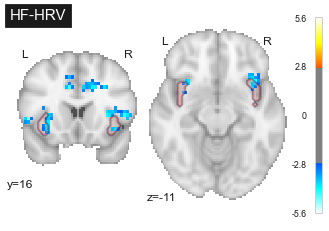

In [19]:
sig_tstat = "FSL_hrv/HFHRV_thresh_tstat.nii.gz"  # this is an inverse map

d = nb.load(sig_tstat).get_fdata()
vmax = d.max()
thr = np.unique(d)[1]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
g = plotting.plot_stat_map(sig_tstat,  title="HF-HRV",
                       display_mode="yz",
                       cut_coords=(16, -11),
                       draw_cross=False, colorbar=False,
                       cmap="cold_hot_r",
                       axes=ax
                      )
g.add_contours("FSL_hrv/harvardoxford-cortical_prob50_InsularCortex_L.nii.gz", alpha=0.2)
g.add_contours("FSL_hrv/harvardoxford-cortical_prob50_InsularCortex_R.nii.gz", alpha=0.2)

g._colorbar_margin = {'left':0,
                      'right': -0.2,
                      'top': 0.037750000000000006,
                      'bottom': 0.037750000000000006}

g._show_colorbar(cmap="cold_hot", 
                 norm=colors.Normalize(-vmax, vmax), 
                 threshold=thr)

plt.savefig("figures/HFHRV.png", dpi=300)

In [20]:
stats = pd.concat([full_sample, hrv, copes_hrv], axis=1, join="inner")
stats = stats[['insular_anatomical_L', 'insular_anatomical_R', "CDS_State", "HeartAware", "hf_power"]]

for x in ['insular_anatomical_L', 'insular_anatomical_R']:
    for y in ["CDS_State", "HeartAware", "hf_power"]:
        mod = smf.ols(formula=f'{y} ~ {x}', 
                      data=stats.apply(zscore))
        res = mod.fit()
        print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              CDS_State   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.111
Date:                Wed, 10 Mar 2021   Prob (F-statistic):              0.297
Time:                        16:28:09   Log-Likelihood:                -68.955
No. Observations:                  49   AIC:                             141.9
Df Residuals:                      47   BIC:                             145.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.684e-17 

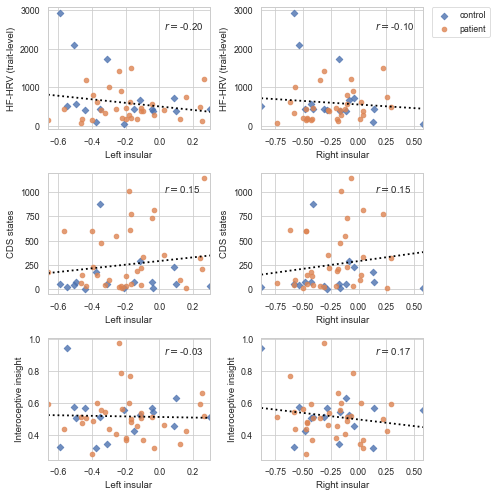

In [21]:
data = pd.concat([full_sample, hrv, copes_hrv], axis=1, join="inner")
select_name = ["Left insular", "Right insular", "HF-HRV (trait-level)",
               "CDS states", "Interoceptive insight","Group"
              ]
select_var = ["insular_anatomical_L", "insular_anatomical_R", "hf_power",
              "CDS_State", "HeartAware", "group"]
data = data[select_var]
data.columns = select_name

stats = [["-0.20", "-0.10"], 
         ["0.15", "0.15"],
         ["-0.03", "0.17"]]

fig, axes = plt.subplots(3, 2, figsize=(7, 7))

for j, region in enumerate(select_name[:2]):
    for i, measure in enumerate(select_name[2:-1]):
        axes[i, j].scatter(data[data["Group"] == "control"][region], 
                     data[data["Group"] == "control"][measure], 
                     label="control", marker="D", alpha=0.8)
        axes[i, j].scatter(data[data["Group"] == "patient"][region], 
                     data[data["Group"] == "patient"][measure],
                     label="patient", marker="o", alpha=0.8)
    
        g = sns.regplot(region, measure, data=data, 
                        fit_reg=True, scatter=False, ci=None, 
                        ax=axes[i, j], color="black")
        g.lines[0].set_linestyle(":")
        
        if region =="Left insular":
            x = 0.025
        elif region =="Right insular":
            x = 0.15

        if measure == "CDS states":
            y = 1000
        elif measure =="HF-HRV (trait-level)":
            y = 2500
        elif measure =="Interoceptive insight":
            y = 0.9
            
        g.annotate(r"$r=$" + stats[i][j], (x, y))
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

plt.savefig("figures/HFHRV_copes.png", dpi=300)